In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
import os
#pd.set_option('display.max_columns', 100)

In [2]:
os.chdir("/home/nishu/python/all/movie_/isko karo share")

In [3]:
ratings_df = pd.read_csv("ratings_small.csv", low_memory=False)
links_df = pd.read_csv("links_small.csv", low_memory=False)
movies_metadata_df = pd.read_csv("movies_metadata.csv", low_memory=False)
credits_df = pd.read_csv("credits.csv", low_memory=False)
keywords_df = pd.read_csv("keywords.csv", low_memory=False)

In [4]:
print("Ratings data contains {} rows and {} columns".format(ratings_df.shape[0], ratings_df.shape[1]))
print("Links data contains {} rows and {} columns".format(links_df.shape[0], links_df.shape[1]))
print("Movie metadata contains {} rows and {} columns".format(movies_metadata_df.shape[0], movies_metadata_df.shape[1]))
print("Credits data contains {} rows and {} columns".format(credits_df.shape[0], credits_df.shape[1]))
print("Keywords data contains {} rows and {} columns".format(keywords_df.shape[0], keywords_df.shape[1]))

Ratings data contains 100004 rows and 4 columns
Links data contains 9125 rows and 3 columns
Movie metadata contains 45466 rows and 24 columns
Credits data contains 45476 rows and 3 columns
Keywords data contains 46419 rows and 2 columns


In [5]:
from ast import literal_eval


In [6]:
# Returns the list top l elements or entire list; whichever is more.
def get_list(x, l=5):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than l elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > l:
            names = names[:l]
        return names

    #Return empty list in case of missing/malformed data
    return []
movies_metadata_df['genres'] = movies_metadata_df['genres'].apply(literal_eval)
movies_metadata_df['genres'] = movies_metadata_df['genres'].apply(get_list)

In [7]:
pd.DataFrame({'feature':ratings_df.dtypes.index, 'dtype':ratings_df.dtypes.values})

,feature,dtype
0,userId,int64
1,movieId,int64
2,rating,float64
3,timestamp,int64


In [8]:
pd.DataFrame({'feature':movies_metadata_df.dtypes.index, 'dtype':movies_metadata_df.dtypes.values})

,feature,dtype
0,adult,object
1,belongs_to_collection,object
2,budget,object
3,genres,object
4,homepage,object
5,id,object
6,imdb_id,object
7,original_language,object
8,original_title,object
9,overview,object


In [9]:
import datetime
min_time = datetime.datetime.fromtimestamp(min(ratings_df.timestamp)).isoformat()
max_time = datetime.datetime.fromtimestamp(max(ratings_df.timestamp)).isoformat()
print('Timestamp for ratings from {} to {}:'.format(min_time, max_time))

Timestamp for ratings from 1995-01-09T17:16:49 to 2016-10-16T23:27:24:


In [10]:
def check_missing(data_df):
    total = data_df.isnull().sum().sort_values(ascending = False)
    percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

check_missing(ratings_df)

,timestamp,rating,movieId,userId
Total,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0


In [11]:
check_missing(movies_metadata_df)

,belongs_to_collection,homepage,tagline,overview,poster_path,runtime,status,release_date,imdb_id,original_language,...,title,video,popularity,production_companies,production_countries,original_title,id,genres,budget,adult
Total,40972.000000,37684.000000,25054.000000,954.000000,386.000000,263.000000,87.000000,87.000000,17.000000,11.000000,...,6.000000,6.000000,5.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0
Percent,90.115691,82.883913,55.104914,2.098271,0.848986,0.578454,0.191352,0.191352,0.037391,0.024194,...,0.013197,0.013197,0.010997,0.006598,0.006598,0.0,0.0,0.0,0.0,0.0


There are 6 movies without a title or 0.01%. Let's drop these rows.

In [12]:
movies_metadata_df.dropna(subset=['title'], inplace=True)
check_missing(movies_metadata_df)

,belongs_to_collection,homepage,tagline,overview,poster_path,runtime,release_date,status,imdb_id,original_language,...,vote_count,popularity,vote_average,production_companies,production_countries,revenue,spoken_languages,title,video,adult
Total,40970.000000,37682.000000,25048.000000,954.000000,383.000000,257.000000,84.000000,81.000000,17.000000,11.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,90.123185,82.890453,55.098988,2.098548,0.842499,0.565332,0.184778,0.178179,0.037396,0.024197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
movies_metadata_df['id'] = pd.to_numeric(movies_metadata_df['id'])

In [14]:
ratings_df.shape

(100004, 4)

In [15]:
ratings_df = ratings_df.merge(movies_metadata_df[['id']], left_on=['movieId'], right_on=['id'], how='inner')

In [16]:
ratings_df['time_dt'] = ratings_df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [17]:
ratings_df.head()

,userId,movieId,rating,timestamp,id,time_dt
0,1,1371,2.5,1260759135,1371,2009-12-14 08:22:15
1,4,1371,4.0,949810302,1371,2000-02-06 09:41:42
2,7,1371,3.0,851869160,1371,1996-12-29 19:49:20
3,19,1371,4.0,855193404,1371,1997-02-06 07:13:24
4,21,1371,3.0,853852263,1371,1997-01-21 18:41:03


In [18]:
ratings_df['year'] = ratings_df['time_dt'].dt.year
ratings_df['month'] = ratings_df['time_dt'].dt.month
ratings_df['day'] = ratings_df['time_dt'].dt.day
ratings_df['dayofweek'] = ratings_df['time_dt'].dt.dayofweek

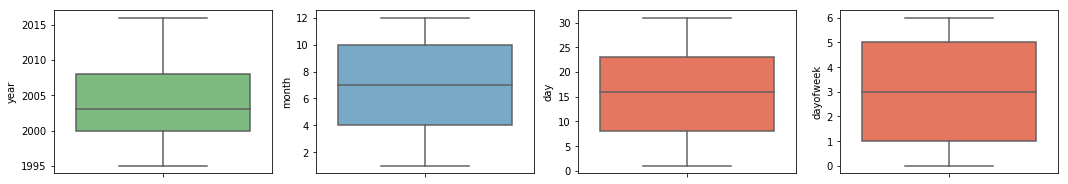

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18,3))
s = sns.boxplot(ax = ax1, y="year", data=ratings_df, palette="Greens",showfliers=True)
s = sns.boxplot(ax = ax2, y="month", data=ratings_df, palette="Blues",showfliers=True)
s = sns.boxplot(ax = ax3, y="day", data=ratings_df, palette="Reds",showfliers=True)
s = sns.boxplot(ax = ax4, y="dayofweek", data=ratings_df, palette="Reds",showfliers=True)
plt.show()

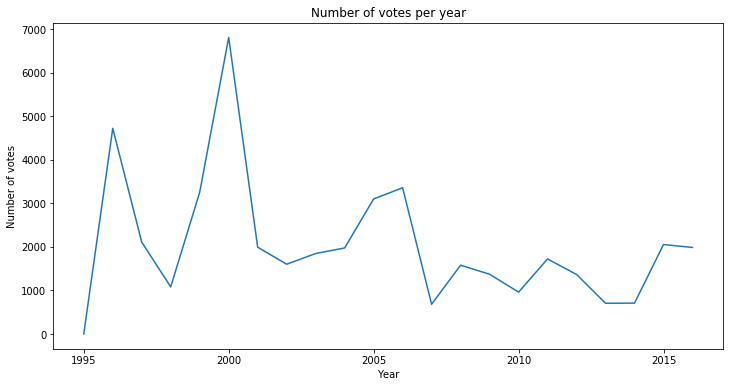

In [20]:
dt = ratings_df.groupby(['year'])['rating'].count().reset_index()
fig, (ax) = plt.subplots(ncols=1, figsize=(12,6))
plt.plot(dt['year'],dt['rating']); plt.xlabel('Year'); plt.ylabel('Number of votes'); plt.title('Number of votes per year')
plt.show()

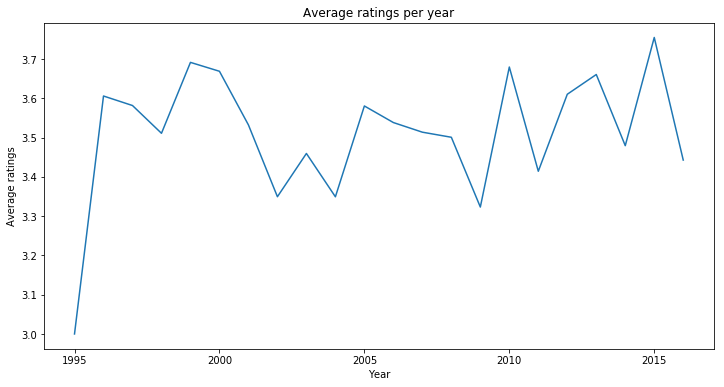

In [21]:
dt = ratings_df.groupby(['year'])['rating'].mean().reset_index()
fig, (ax) = plt.subplots(ncols=1, figsize=(12,6))
plt.plot(dt['year'],dt['rating']); plt.xlabel('Year'); plt.ylabel('Average ratings'); plt.title('Average ratings per year')
plt.show()

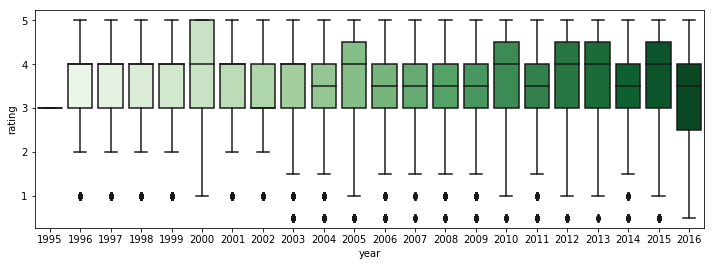

In [22]:
fig, (ax) = plt.subplots(ncols=1, figsize=(12,4))
s = sns.boxplot(x='year', y="rating", data=ratings_df, palette="Greens",showfliers=True)
plt.show()

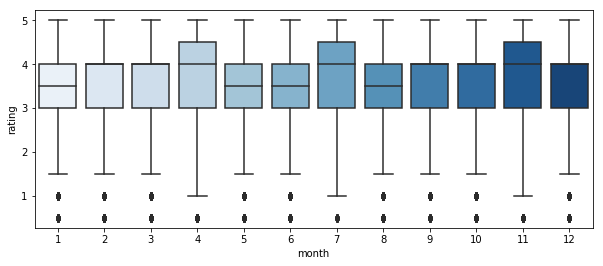

In [23]:
fig, (ax) = plt.subplots(ncols=1, figsize=(10,4))
s = sns.boxplot(x='month', y="rating", data=ratings_df, palette="Blues",showfliers=True)
plt.show()

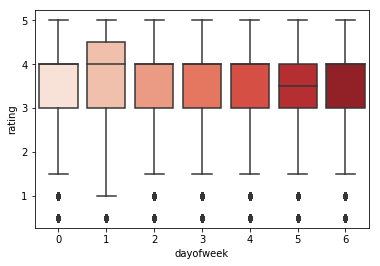

In [24]:
fig, (ax) = plt.subplots(ncols=1, figsize=(6,4))
s = sns.boxplot(x='dayofweek', y="rating", data=ratings_df, palette="Reds",showfliers=True)
plt.show()

### Observations:

**We are not observing a special behavior other than variation in time of the ratings averages, with a descending trend from 1995 to 2004, also with 2 peaks in 1997 and 1999 and ascending trend since 2004 to 2012, to start decreasing again.
Number of votes shows a lot of peaks and valleys, and also an ascendent trend to 2005, followed by a descending one from 2005, a sharp increase to 2015.
There are a number of outliers for each year, month and day of week. We observe a strange alignment of the rating distribution per year intervals 1996-2002, 2003-2011 and 2012-2017 which could prompt us to conclude that the selection used some artificial sampling.**

### Users distribution
Let's check if we have special users (users that give many votes, users that give preponderently high ratings, users that give mostly low ratings, users that are giving the perfect average value). Also, users with only one vote.

In [25]:
print("There is a total of {} users, with an average number of {} votes.".format(ratings_df.userId.nunique(), \
                                                round(ratings_df.shape[0]/ratings_df.userId.nunique()),2))

There is a total of 671 users, with an average number of 67 votes.


In [26]:
print("Top 5 voting users:\n")
tmp = ratings_df.userId.value_counts()[:5]
pd.DataFrame({'Votes':tmp.values, 'Id':tmp.index})

Top 5 voting users:



,Votes,Id
0,896,564
1,753,547
2,565,15
3,553,73
4,542,452


In [27]:
tmp = ratings_df.groupby(['userId'])['rating'].mean().reset_index()
tmp['rating'] = tmp['rating'].apply(lambda x: round(x,3))
df_max = tmp[tmp['rating']==5]
df_min = tmp[tmp['rating']==0.5]
print("Users giving only '5': {}\nUsers giving only '0.5':{}".format(df_max.shape[0], df_min.shape[0]))

Users giving only '5': 1
Users giving only '0.5':0


In [28]:
mean_rating = round(ratings_df['rating'].mean(),3)
print("Average value of rating is {}.".format(mean_rating))
print("There are {} users that have their average score with the overall average score (approx. with 3 decimals).".format(\
                            tmp[tmp['rating']==mean_rating]['userId'].nunique()))

Average value of rating is 3.561.
There are 1 users that have their average score with the overall average score (approx. with 3 decimals).


# Movie distribution
Let's see what are the movies with the largest number of votes, with the biggest rating, with the lowest rating, how many movies have ratings close to average rating.

In [29]:
print("There is a total of {} movies, with an average number of {} votes.".format(ratings_df.movieId.nunique(), \
                                                round(ratings_df.shape[0]/ratings_df.movieId.nunique()),2))

There is a total of 2830 movies, with an average number of 16 votes.


In [30]:
print("Top 10 voted movies:\n")
tmp = ratings_df.movieId.value_counts()[:10]
pd.DataFrame({'Votes':tmp.values, 'id':tmp.index})

Top 10 voted movies:



,Votes,id
0,324,296
1,311,318
2,304,593
3,291,260
4,274,480
5,244,527
6,228,110
7,224,608
8,218,780
9,215,588


In [31]:
top_10 = pd.DataFrame({'Votes':tmp.values, 'id':tmp.index}).merge(movies_metadata_df)
top_10

,Votes,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,324,296,False,"{'id': 528, 'name': 'The Terminator Collection...",200000000,"[Action, Thriller, Science Fiction]",NaN,tt0181852,en,Terminator 3: Rise of the Machines,...,2003-07-02,435000000.0,109.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Machines Will Rise.,Terminator 3: Rise of the Machines,False,5.9,2177.0
1,311,318,False,NaN,8000000,"[Drama, Thriller]",NaN,tt0120753,en,The Million Dollar Hotel,...,2000-02-09,0.0,122.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,The Million Dollar Hotel,False,5.9,76.0
2,304,593,False,NaN,0,"[Drama, Science Fiction, Adventure, Mystery]",NaN,tt0069293,ru,Солярис,...,1972-03-20,0.0,167.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Solaris,False,7.7,364.0
3,291,260,False,NaN,0,"[Action, Thriller, Mystery]",NaN,tt0026029,en,The 39 Steps,...,1935-06-01,0.0,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Handcuffed to the girl who double-crossed him,The 39 Steps,False,7.4,217.0
4,274,480,False,NaN,0,"[Comedy, Drama, Romance]",NaN,tt0265343,hi,Monsoon Wedding,...,2001-08-30,0.0,114.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"A stressed father, a bride-to-be with a secret...",Monsoon Wedding,False,6.8,59.0
5,244,527,False,"{'id': 300546, 'name': 'Once were Warriors Col...",0,[Drama],NaN,tt0110729,en,Once Were Warriors,...,1994-09-02,2201126.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"A family in crisis, a life in chaos... Nothing...",Once Were Warriors,False,7.6,106.0
6,228,110,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,fr,Trois couleurs : Rouge,...,1994-05-27,0.0,99.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Three Colors: Red,False,7.8,246.0
7,224,608,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,tt0120912,en,Men in Black II,...,2002-07-03,441818803.0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0
8,218,780,False,NaN,0,"[Drama, History]",NaN,tt0019254,fr,La passion de Jeanne d'Arc,...,1928-04-21,0.0,110.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,An Immortal Screen Classic that will live Fore...,The Passion of Joan of Arc,False,8.2,159.0
9,215,588,False,"{'id': 64748, 'name': 'Silent Hill Collection'...",50000000,"[Horror, Mystery]",http://www.sonypictures.com/homevideo/silenthill/,tt0384537,en,Silent Hill,...,2006-04-21,97607453.0,125.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,We've been expecting you.,Silent Hill,False,6.3,1093.0


In [32]:
tmp = ratings_df.movieId.value_counts()
df = pd.DataFrame({'Votes':tmp.values, 'Id':tmp.index})
print("There are {} movies that were voted only once.".format(df[df['Votes']==1].nunique().values[0]))

There are 1 movies that were voted only once.


In [33]:
tmp = ratings_df.groupby(['movieId'])['rating'].mean().reset_index()
tmp['rating'] = tmp['rating'].apply(lambda x: round(x,3))
df_max = tmp[tmp['rating']==5]
df_min = tmp[tmp['rating']==0.5]
print("Movies with only '5': {}\nMovies with only '0.5':{}".format(df_max.shape[0], df_min.shape[0]))


Movies with only '5': 86
Movies with only '0.5':26


Note: these values should be interpreted considering that we only use a 20% sample from the ratings_df total data.

In [34]:
mean_rating = round(ratings_df['rating'].mean(),3)
print("Average value of rating is {}.".format(mean_rating))
print("There are {} movies that have their average score with the overall average score (approx. with 3 decimals).".format(\
                            tmp[tmp['rating']==mean_rating]['movieId'].nunique()))

Average value of rating is 3.561.
There are 1 movies that have their average score with the overall average score (approx. with 3 decimals).


In [35]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=17,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(movies_metadata_df['genres'], title = 'Movie Genres Prevalence in The Movie Dataset')

ModuleNotFoundError: No module named 'wordcloud'

Go to top

Static rating model - top 10 movies
Let's build now a baseline static rating model to create the top 10 movies.

We use the formulas borrowed from two Kernels:
We will use for this the IMDB weighted rating formula, as following:

IMDB=vv+mR+mv+mC
 
where:

IMDB is weighted rating;
v is the number of votes for the movie;
m is the minimum votes required to be included in the calculation;
R is the average rating of the movie;
C is the mean vote across the whole set.
Let's calculate these values. For m, we consider quantile 0.9.

In [36]:
tmp = ratings_df.groupby(['movieId'])['rating'].mean()
R = pd.DataFrame({'id':tmp.index, 'R': tmp.values})
tmp = ratings_df.groupby(['movieId'])['rating'].count()
v = pd.DataFrame({'id':tmp.index, 'v': tmp.values})
C = ratings_df['rating'].mean()

In [37]:
m_df = movies_metadata_df.merge(R, on=['id'])
m_df = m_df.merge(v, on=['id'])
m_df['C'] = C
m= m_df['v'].quantile(0.9)
m_df['m'] = m

In [38]:
m_df['IMDB'] = (m_df['v'] / (m_df['v'] + m_df['m'])) * m_df['R'] + (m_df['m'] / (m_df['v'] + m_df['m'])) * m_df['C']

In [39]:
m_df.sort_values(by=['IMDB'], ascending=False).head(10)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,R,v,C,m,IMDB
747,False,NaN,8000000,"[Drama, Thriller]",NaN,318,tt0120753,en,The Million Dollar Hotel,The Million Dollar Hotel starts with a jump fr...,...,NaN,The Million Dollar Hotel,False,5.9,76.0,4.487138,311,3.560986,44.0,4.372348
102,False,NaN,21000000,"[Comedy, Drama, Romance]",NaN,858,tt0108160,en,Sleepless in Seattle,A young boy who tries to set his dad up on a d...,...,"What if someone you never met, someone you nev...",Sleepless in Seattle,False,6.5,630.0,4.487500,200,3.560986,44.0,4.320424
48,False,"{'id': 300546, 'name': 'Once were Warriors Col...",0,[Drama],NaN,527,tt0110729,en,Once Were Warriors,A drama about a Maori family lving in Auckland...,...,"A family in crisis, a life in chaos... Nothing...",Once Were Warriors,False,7.6,106.0,4.303279,244,3.560986,44.0,4.189873
1042,False,"{'id': 528, 'name': 'The Terminator Collection...",200000000,"[Action, Thriller, Science Fiction]",NaN,296,tt0181852,en,Terminator 3: Rise of the Machines,It's been 10 years since John Connor saved Ear...,...,The Machines Will Rise.,Terminator 3: Rise of the Machines,False,5.9,2177.0,4.256173,324,3.560986,44.0,4.173053
929,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,608,tt0120912,en,Men in Black II,"Kay and Jay reunite to provide our best, last ...",...,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0,4.256696,224,3.560986,44.0,4.142475
174,False,NaN,0,"[Action, Thriller, Mystery]",NaN,260,tt0026029,en,The 39 Steps,"While on vacation in London, Canadian Richard ...",...,Handcuffed to the girl who double-crossed him,The 39 Steps,False,7.4,217.0,4.221649,291,3.560986,44.0,4.134876
925,False,NaN,0,"[Action, Western, Thriller]",NaN,4993,tt0062626,en,5 Card Stud,The players in an ongoing poker game are being...,...,A card cheat was hung... then all hell broke l...,5 Card Stud,False,6.0,20.0,4.182500,200,3.560986,44.0,4.070424
1804,False,NaN,35000000,[Comedy],http://licensetowedthemovie.warnerbros.com/,2959,tt0762114,en,License to Wed,"Newly engaged, Ben and Sadie can't wait to sta...",...,First came love... then came Reverend Frank.,License to Wed,False,5.3,258.0,4.178218,202,3.560986,44.0,4.067819
650,False,NaN,0,"[Drama, Science Fiction, Adventure, Mystery]",NaN,593,tt0069293,ru,Солярис,Ground control has been receiving strange tran...,...,NaN,Solaris,False,7.7,364.0,4.138158,304,3.560986,44.0,4.065182
2400,False,NaN,5000000,[Comedy],NaN,4226,tt0212235,en,Shriek If You Know What I Did Last Friday the ...,Another spoof of the Scream/I Know What You Di...,...,NaN,Shriek If You Know What I Did Last Friday the ...,False,4.8,70.0,4.227273,132,3.560986,44.0,4.060701


In [40]:
m_df[['title', 'IMDB']].sort_values(by=['IMDB'], ascending=False).head(10)

,title,IMDB
747,The Million Dollar Hotel,4.372348
102,Sleepless in Seattle,4.320424
48,Once Were Warriors,4.189873
1042,Terminator 3: Rise of the Machines,4.173053
929,Men in Black II,4.142475
174,The 39 Steps,4.134876
925,5 Card Stud,4.070424
1804,License to Wed,4.067819
650,Solaris,4.065182
2400,Shriek If You Know What I Did Last Friday the ...,4.060701


Top 10 by number of votes

In [41]:
m_df['R_x_v'] = m_df['R'] * m_df['v']

In [42]:
m_df[['title', 'v']].sort_values(by=['v'], ascending=False).head(10)

,title,v
1042,Terminator 3: Rise of the Machines,324
747,The Million Dollar Hotel,311
650,Solaris,304
174,The 39 Steps,291
885,Monsoon Wedding,274
48,Once Were Warriors,244
53,Three Colors: Red,228
929,Men in Black II,224
1109,The Passion of Joan of Arc,218
1646,Silent Hill,215


Top 10 by product of average rating and number of votes

In [43]:
m_df[['title', 'R_x_v']].sort_values(by=['R_x_v'], ascending=False).head(10)

,title,R_x_v
747,The Million Dollar Hotel,1395.5
1042,Terminator 3: Rise of the Machines,1379.0
650,Solaris,1258.0
174,The 39 Steps,1228.5
48,Once Were Warriors,1050.0
885,Monsoon Wedding,1015.5
929,Men in Black II,953.5
53,Three Colors: Red,899.5
102,Sleepless in Seattle,897.5
1804,License to Wed,844.0


Memory cleanup

In [44]:
del tmp, top_10
gc.collect()


20234

Recommendation simple models
Simple model using similarities of movie title
The model will use similarities, calculated based on movie title.

We will use the already calculated m_df dataset.
The methods to calculate cosine simmilarities are taken from:


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english',max_features=10000)
tokens = m_df[['title']]
tokens['title'] = tokens['title'].fillna('')
tfidf_matrix = tfidf.fit_transform(tokens['title'])
print(tfidf_matrix.shape)
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim.shape)
indices = pd.Series(tokens.index, index=tokens['title']).drop_duplicates()
indices

(2831, 3222)
(2831, 2831)


C:\Users\vikas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


title
Heat                                                  0
GoldenEye                                             1
Cutthroat Island                                      2
Casino                                                3
Sense and Sensibility                                 4
Four Rooms                                            5
Get Shorty                                            6
Leaving Las Vegas                                     7
The City of Lost Children                             8
Twelve Monkeys                                        9
Dead Man Walking                                     10
To Die For                                           11
Mr. Holland's Opus                                   12
French Twist                                         13
From Dusk Till Dawn                                  14
Antonia's Line                                       15
Angels and Insects                                   16
Nick of Time                              

In [46]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # index of the movie that matches the title
    idx = indices[title]

    # similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # movie indices
    movie_indices = [i[0] for i in sim_scores]

    # top 10 most similar movies
    return tokens['title'].iloc[movie_indices]

In [6]:
get_recommendations('Heat')

NameError: name 'get_recommendations' is not defined

In [ ]:
get_recommendations('Sleepless in Seattle')

Combined model, using similarity and popularity
This model uses both similarity factor, based on movie title and popularity score, based on IMDB score.

We modify the get_recommendation function to return a number of 50 similar titles; we order the titles using popularity score.



In [ ]:
tfidf = TfidfVectorizer(stop_words='english',max_features=10000)
tokens = m_df[['title']]
tokens['title'] = tokens['title'].fillna('')
tfidf_matrix = tfidf.fit_transform(tokens['title'])
print(tfidf_matrix.shape)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim.shape)
indices = pd.Series(tokens.index, index=tokens['title']).drop_duplicates()

In [ ]:
def get_imdb_score(df, indices):
    # select the data from similarity indices
    tmp = df[df.id.isin(indices)]
    # sort the data by IMDB score
    tmp = tmp.sort_values(by='IMDB', ascending=False)
    # return title and IMDB score
    return tmp[['title','IMDB']].head(10)

In [ ]:
def get_10_recommendations_simpol(title, cosine_sim=cosine_sim):
    # index of the movie that matches the title
    idx = indices[title]

    # similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # scores of the 20 most similar movies
    sim_scores = sim_scores[1:21]
    
    # movie indices
    movie_indices = [i[0] for i in sim_scores]

    # get popularity scores
    pop_scores = get_imdb_score(m_df, movie_indices)
    
    return list(pop_scores['title'])

In [ ]:
get_10_recommendations_simpol('The Million Dollar Hotel')

In [ ]:
get_10_recommendations_simpol('Judgment Night')

In [ ]:
get_10_recommendations_simpol('High Noon')

In [ ]:
get_10_recommendations_simpol('Ariel')

Go to top

Conclusion
Three simple recommendation models were created, as following:

One model, user agnostic, based on ratings averages per movie and number of votes, it is basically the IMDB rating model; this model provide a top-10 list of movies recommendation, starting from a movie selected by a user;
One model, depending on simmilarities of titles;
One model, depending on similarities of titles and IMDB rating.
References
I took inspiration from several sources.

[1] https://medium.com/recombee-blog/machine-learning-for-recommender-systems-part-1-algorithms-evaluation-and-cold-start-6f696683d0ed


In [ ]:
a = '''Lorem ipsum dolor sit amet,
consectetur adipiscing elit,sed do eiusmod tempor incididunt
ut labore et dolore magna aliqua.'''
print(a)

In [ ]:
a = " Hello, World! "
print(a.capitalize())

In [ ]:
a = "Vikas"
b = "vikas"
print(a.capitalize())
print(b.capitalize())